## Imports

In [1]:
import os
import warnings
warnings.filterwarnings("ignore") # remove some scikit-image warnings


from monai.apps import DecathlonDataset, TciaDataset
from monai.data import DataLoader
from monai.transforms import (
    LoadImageD,LoadImaged,
    EnsureChannelFirstD, EnsureChannelFirstd,
    Compose,
    OrientationD,
    OrientationD,
    Rotate90D, Rotate90,
    ResampleToMatchd
)
from monai.apps.tcia import TCIA_LABEL_DICT

import torch
import numpy as np
import random
import sys
from tqdm import tqdm
import pickle as pkl
import matplotlib.pyplot as plt
import cv2

## Hyperparamaters

In [2]:
crt_dir = os.getcwd()
datasets_path = f'{crt_dir}/datasets/Rad/'

# DOWNLOAD_FLAG = not os.path.exists(datasets_path)
DOWNLOAD_FLAG = False

KEYS = ["image", "seg"]

In [3]:
# from glob import glob
os.path.isdir(datasets_path)

True

## PREPROCESSING TRANSFORMS

In [4]:
# To decode the specific labels we need LoadImage and ResampleToMatchd based on: https://docs.monai.io/en/stable/apps.html
# Not like in MSD, Data comes with patient alligned to the right wall (instead of left), from top of the lungs to the bottom
# We need to rotate on those axis to keep our models alligned with MSD
base_transform = Compose([LoadImaged(reader="PydicomReader", keys=["seg"], 
                                     label_dict=TCIA_LABEL_DICT["NSCLC-Radiomics"]),
                          EnsureChannelFirstd(keys = KEYS),
                          ResampleToMatchd(keys="image", key_dst="seg"),
                          Rotate90D(k=2, spatial_axes=(1, 2), keys = KEYS)
                         ])

In [5]:
# ### TRAINING DATA ###
train_name = 'training' # From Monai: ['training', 'validation', 'test']
# # train_dataset = DecathlonDataset(root_dir = datasets_path,
# #                         task = "Task06_Lung", section = train_name,
# #                         transform = base_transform, download = DOWNLOAD_FLAG)
train_dataset = TciaDataset(root_dir = datasets_path, section = train_name, download = DOWNLOAD_FLAG,
                           collection = "NSCLC-Radiomics", transform = ())

In [6]:
train_dataset[0]

{'image': metatensor([[[-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
          [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
          [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
          ...,
          [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
          [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
          [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.]],
 
         [[-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
          [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
          [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
          ...,
          [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
          [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
          [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.]],
 
         [[-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
          [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
          [-1024., -1024., 

In [7]:
def get_image_and_label(data):
    transformed = base_transform(data)
    transf_label = transformed['seg'].permute(1, 2, 3, 0)
    
    return transformed['image'], transf_label[..., 1].unsqueeze(0)

In [34]:
# no_slices = []

# for ds_idx in tqdm(range(len(train_dataset))):
#     # print(train_dataset[ds_idx]['image'].shape)
#     # break
#     no_slices.append(train_dataset[ds_idx]['image'].shape[-1])

# # print(np.array(no_slices).mean())

# mean_training_slices = np.array(no_slices).mean()
mean_training_slices = 120.52522255192878
truncated_rad_tr_slices = round(mean_training_slices, 0)

In [37]:
mean_for_msd = 283
replaced_patients_msd = 9

In [40]:
replace_patients_rad = int(round(replaced_patients_msd * mean_for_msd / truncated_rad_tr_slices, 0))
replace_patients_rad

21

In [41]:
from eda_src.normalization import min_max_normalization
from eda_src.random_sample_funcs import rmse_dev_vs_val

In [45]:
computational_effort_train_path = f'./msd_eda1_computational_effort_training.pkl'

binning_volume_tr, _, bins_2d_tr, _, _, _ = pkl.load(open(computational_effort_train_path, 'rb'))
normalized_bins_tr = min_max_normalization(np.sum(bins_2d_tr, axis = 0))

In [64]:
def pick_best_samples(target_bins, no_tries, no_samples = 9, set_idx = None):
    max_rmse = 0
    best_heatmap, best_idx = None, None
    
    for crt_try in range(no_tries):
        print(f'Try {crt_try + 1}/{no_tries}')
        rand_idx = random.sample(range(len(train_dataset)), no_samples)

        if set_idx is not None:
            rand_idx = set_idx


        dev_heatmap = np.zeros((512, 512))

        for count, ds_idx in enumerate(rand_idx):
            print(f'Adding patient: {count + 1}/{no_samples}')
            _, label = get_image_and_label(train_dataset[ds_idx])
            dev_heatmap += label.squeeze().sum(axis=2).numpy()
            
        print(f'Heatmap shape: {dev_heatmap.shape}')
        normalised_dev_heatmap = min_max_normalization(dev_heatmap)

        rmse = rmse_dev_vs_val(normalised_dev_heatmap, target_bins)
        
        print(f'For current indices: {rand_idx}\nRMSE  = {rmse:.3f}')
        
        if rmse > max_rmse:
            max_rmse = rmse
            best_heatmap = dev_heatmap
            best_idx = rand_idx

        if set_idx is not None:
            break
    
    return best_heatmap, best_idx, max_rmse

In [65]:
best_heatmap, best_idx, max_rmse = pick_best_samples(normalized_bins_tr, 5, no_samples=replace_patients_rad, set_idx=[271, 114, 121, 97, 33, 240, 168, 214, 164, 302, 12, 35, 225, 105, 221, 48, 88, 16, 71, 106, 197])


Try 1/5
Adding patient: 1/21
Adding patient: 2/21
Adding patient: 3/21
Adding patient: 4/21
Adding patient: 5/21
Adding patient: 6/21
Adding patient: 7/21
Adding patient: 8/21
Adding patient: 9/21
Adding patient: 10/21
Adding patient: 11/21
Adding patient: 12/21
Adding patient: 13/21
Adding patient: 14/21
Adding patient: 15/21
Adding patient: 16/21
Adding patient: 17/21
Adding patient: 18/21
Adding patient: 19/21
Adding patient: 20/21
Adding patient: 21/21
Heatmap shape: (512, 512)
For current indices: [271, 114, 121, 97, 33, 240, 168, 214, 164, 302, 12, 35, 225, 105, 221, 48, 88, 16, 71, 106, 197]
RMSE  = 0.050


In [49]:
# For current indices: [68, 24, 179, 42, 37, 317, 25, 58, 208, 244, 31, 328, 309, 266, 71, 313, 146, 216, 155, 14, 242]
# RMSE  = 0.043
# For current indices: [133, 88, 22, 246, 146, 221, 236, 307, 168, 165, 116, 44, 209, 94, 40, 333, 298, 245, 167, 144, 300]
# RMSE  = 0.043
# For current indices: [271, 114, 121, 97, 33, 240, 168, 214, 164, 302, 12, 35, 225, 105, 221, 48, 88, 16, 71, 106, 197]
# RMSE  = 0.050

146


In [53]:
remove_bed_bbox_2d = (60, 450, 119, 425)


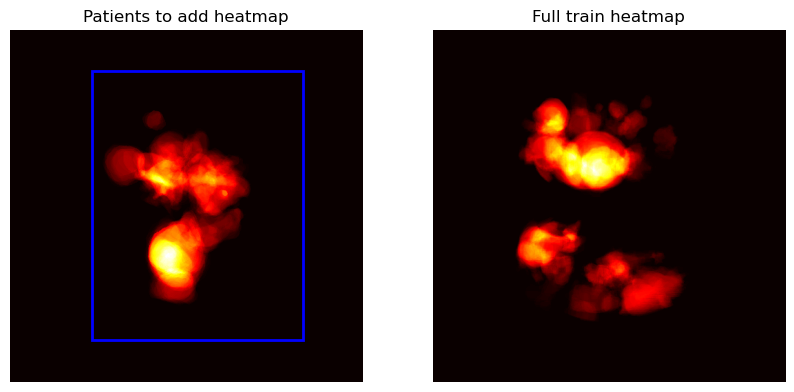

In [69]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

if remove_bed_bbox_2d is not None:
    h_min, h_max, w_min, w_max = remove_bed_bbox_2d
    ax[0].add_patch(plt.Rectangle((w_min, h_min), w_max - w_min, h_max - h_min, fill=False, edgecolor='blue', lw=2))

ax[0].imshow(best_heatmap, cmap='hot')


ax[0].axis('off')
ax[0].set_title(f'RMSE: {max_rmse:.3f}')
ax[0].set_title('Patients to add heatmap')
ax[1].imshow(normalized_bins_tr, cmap='hot')
ax[1].axis('off')
ax[1].set_title('Full train heatmap')


plt.show()



In [73]:
def min_max_normalize(img):
    no_stacks = img.shape[-1]

    for i in range(no_stacks):
        img[:, :, :, i] = (img[:, :, :, i] - img[:, :, :, i].min()) / (img[:, :, :, i].max() - img[:, :, :, i].min())

    return img

def remove_bed(img, bbox):
    '''
    Remove the bed from the image
    '''

    # print(img.shape)

    min_img = img.min()
    new_img = torch.ones_like(img) * min_img

    new_img[:, bbox[0]:bbox[1], bbox[2]:bbox[3], :] = img[:, bbox[0]:bbox[1], bbox[2]:bbox[3], :]

    return new_img


In [79]:
# For current indices: [271, 114, 121, 97, 33, 240, 168, 214, 164, 302, 12, 35, 225, 105, 221, 48, 88, 16, 71, 106, 197]

best_indices = [271, 114, 121, 97, 33, 240, 168, 214, 164, 302, 12, 35, 225, 105, 221, 48, 88, 16, 71, 106, 197]
os.makedirs(f'{datasets_path}/rad_tr_samples', exist_ok=True)
os.makedirs(f'{datasets_path}/rad_tr_samples/images', exist_ok=True)
os.makedirs(f'{datasets_path}/rad_tr_samples/labels', exist_ok=True)

best_index_offset = 42

for idx in best_indices:
    print(f'Processing patient {idx}')
    image, label = get_image_and_label(train_dataset[idx])
    image = min_max_normalize(image)
    image = remove_bed(image, remove_bed_bbox_2d)
    
    torch.save(image, f'{datasets_path}/rad_tr_samples/images/patient_{best_index_offset}.pt')
    torch.save(label, f'{datasets_path}/rad_tr_samples/labels/patient_{best_index_offset}.pt')

    best_index_offset += 1


Processing patient 271
Processing patient 114
Processing patient 121
Processing patient 97
Processing patient 33
Processing patient 240
Processing patient 168
Processing patient 214
Processing patient 164
Processing patient 302
Processing patient 12
Processing patient 35
Processing patient 225
Processing patient 105
Processing patient 221
Processing patient 48
Processing patient 88
Processing patient 16
Processing patient 71
Processing patient 106
Processing patient 197
